# Feature Engineering

In [4]:
import data_prep
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
sql="""
with data as (
SELECT
    DATETIME(trip_start_timestamp, 'America/Chicago') trip_start_timestamp, 
    DATETIME(trip_end_timestamp, 'America/Chicago') trip_end_timestamp, 
    trip_miles,  
    trip_seconds,
    pickup_latitude, 
    pickup_longitude, 
    dropoff_latitude, 
    dropoff_longitude,
    fare
FROM
    `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE 
    fare > 0 
    AND pickup_latitude IS NOT NULL
    AND trip_seconds IS NOT NULL
    AND dropoff_latitude IS NOT NULL
    AND pickup_longitude IS NOT NULL
    AND dropoff_latitude IS NOT NULL
    AND fare IS NOT NULL 
    AND trip_miles > 0 
    AND trip_miles IS NOT NULL
    
ORDER BY 
    RAND()
LIMIT 100000
)
SELECT *, 
    CAST(trip_start_timestamp AS DATE) trip_start_dt,
    CAST(trip_end_timestamp AS DATE) trip_end_dt,
    DATETIME_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) trip_minutes,
    EXTRACT(YEAR FROM trip_start_timestamp) start_year,
    EXTRACT(MONTH FROM trip_start_timestamp) start_month,
    EXTRACT(DAY FROM trip_start_timestamp) start_day,
    EXTRACT(HOUR FROM trip_start_timestamp) start_hour,
    EXTRACT(YEAR FROM trip_end_timestamp) end_year,
    EXTRACT(MONTH FROM trip_end_timestamp) end_month,
    EXTRACT(DAY FROM trip_end_timestamp) end_day,
    EXTRACT(HOUR FROM trip_end_timestamp) end_hour,
    FORMAT_DATE('%a', DATE(trip_start_timestamp)) weekday
FROM data
WHERE
    trip_start_timestamp > '2016-01-01 00:00:00'
"""

raw = data_prep.get_raw(sql)
raw.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,trip_seconds,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare,trip_start_dt,...,trip_minutes,start_year,start_month,start_day,start_hour,end_year,end_month,end_day,end_hour,weekday
0,2018-12-07 13:15:00,2018-12-07 13:30:00,2.30,1140,41.880994,-87.632746,41.914616,-87.631717,11.50,2018-12-07,...,15,2018,12,7,13,2018,12,7,13,Fri
1,2018-11-08 08:45:00,2018-11-08 11:15:00,47.10,9531,41.706126,-87.598256,41.761578,-87.572782,130.50,2018-11-08,...,150,2018,11,8,8,2018,11,8,11,Thu
2,2016-11-15 09:15:00,2016-11-15 10:30:00,18.00,3763,41.979071,-87.903040,41.892508,-87.626215,46.50,2016-11-15,...,75,2016,11,15,9,2016,11,15,10,Tue
3,2017-09-13 11:00:00,2017-09-13 11:15:00,1.09,458,41.892073,-87.628874,41.880994,-87.632746,6.75,2017-09-13,...,15,2017,9,13,11,2017,9,13,11,Wed
4,2017-09-22 13:15:00,2017-09-22 13:45:00,6.80,1260,41.899602,-87.633308,41.953582,-87.723452,21.00,2017-09-22,...,30,2017,9,22,13,2017,9,22,13,Fri


#### <font color='green'>Q1: Which regions have most pickups?</font>

In [6]:
# discover relationship between pickup location and frequency

long = 'pickup_longitude'
lat = 'pickup_latitude'
divisor = 280
name = 'count'
data_prep.map_visualization(raw, long, lat, name, divisor)

### <font color='green'>Q2: Which regions have most dropoff?</font>

In [7]:
# discover relationship between dropoff location and frequency

long = 'dropoff_longitude'
lat = 'dropoff_latitude'
divisor = 280
name = 'count'
data_prep.map_visualization(raw, long, lat, name, divisor)

### <font color='red'>Takeaway #1:</font> <font color='orange'> To Summarize regarding Q1 and Q2, it seems like the location(latitude&longtitude) is a factor related to the taxi demands, which will affect the fare price.</font>

### <font color='green'>Q3: What region has more expensive pickup?</font>

In [8]:
long = 'pickup_longitude'
lat = 'pickup_latitude'
divisor = 5
name = 'avg_fare'
data_prep.map_visualization(raw, long, lat, name, divisor)

### <font color='green'>Q4: What region has more expensive dropoff?</font>

In [9]:
long = 'dropoff_longitude'
lat = 'dropoff_latitude'
divisor = 5
name = 'avg_fare'
data_prep.map_visualization(raw, long, lat, name, divisor)

### <font color='red'>Takeaway #2:</font> <font color='orange'> It confirms that location will affect the fare price, and the popular pickup/dropoff location always has lowest fare price, except airport.</font>

### <font color='green'>Q5: When are the peak hours and off-peak hours for taking taxi?</font>

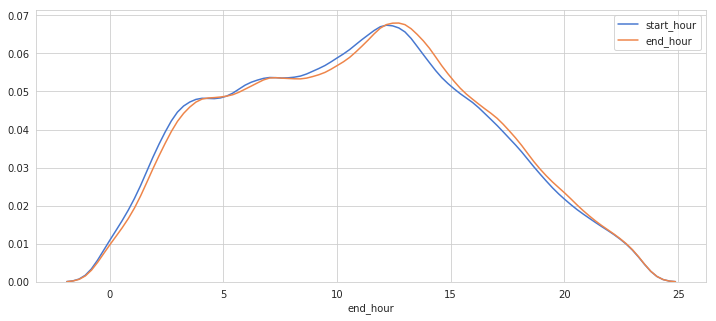

Percentage of rides during working hours 0.6789853530174332


In [10]:
data_prep.dist_plot(raw, ['start_hour', 'end_hour'])
print('Percentage of rides during working hours', raw[(raw['start_hour']>=7) & (raw['start_hour']<=19)].shape[0]/raw.shape[0])

There are some peak hours for pickup and dropoff

### <font color='green'>Q6: What is the peak day and off-peak day in a month for taking taxi?</font>

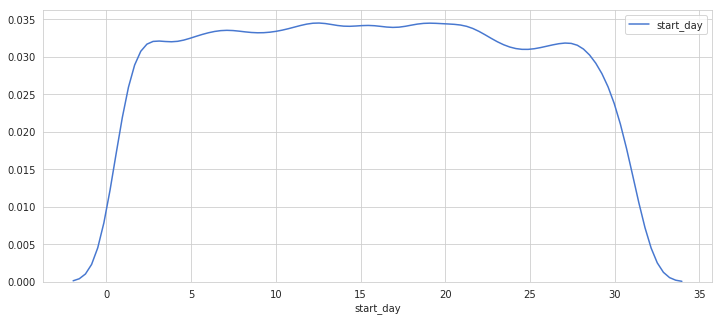

In [11]:
data_prep.dist_plot(raw, ['start_day'])

From the perspective of day in a month, it doesn't see a strong pattern affect taxi demand.

### <font color='green'>Q7: When are the peak day and off-peak day in a week for price? In terms of pickup</font>

In [12]:
raw['dayOfWeek'] = raw['weekday'].apply(data_prep.dayofweek)

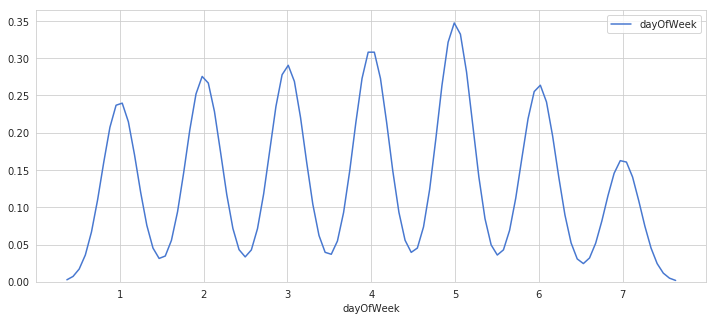

In [13]:
data_prep.dist_plot(raw, ['dayOfWeek'])

It seems like Friday is the peak day in a week

### <font color='green'>Q8: When are the peak day and off-peak day in a year for price? In terms of pickup? Does holiday affect the taxi demands?</font>

In [14]:
raw['dayOfYear'] = raw['trip_start_timestamp'].apply(data_prep.dayofyear)

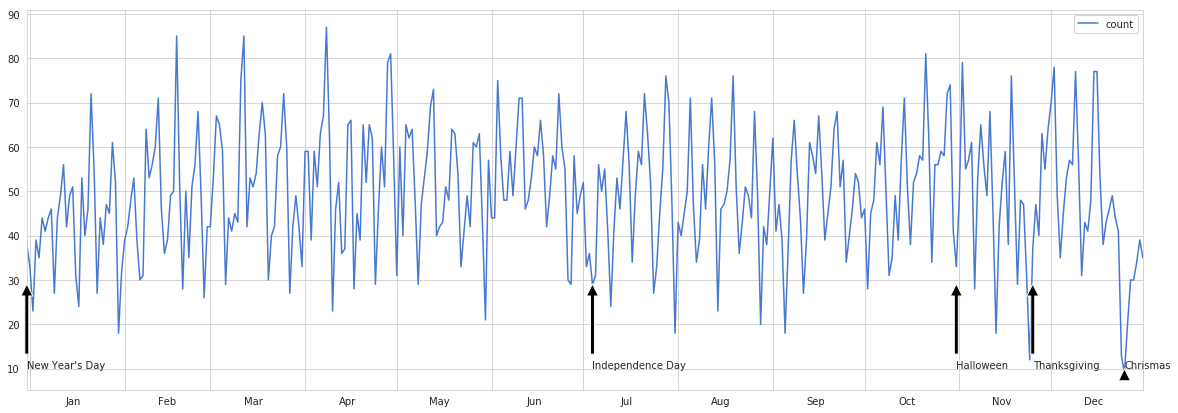

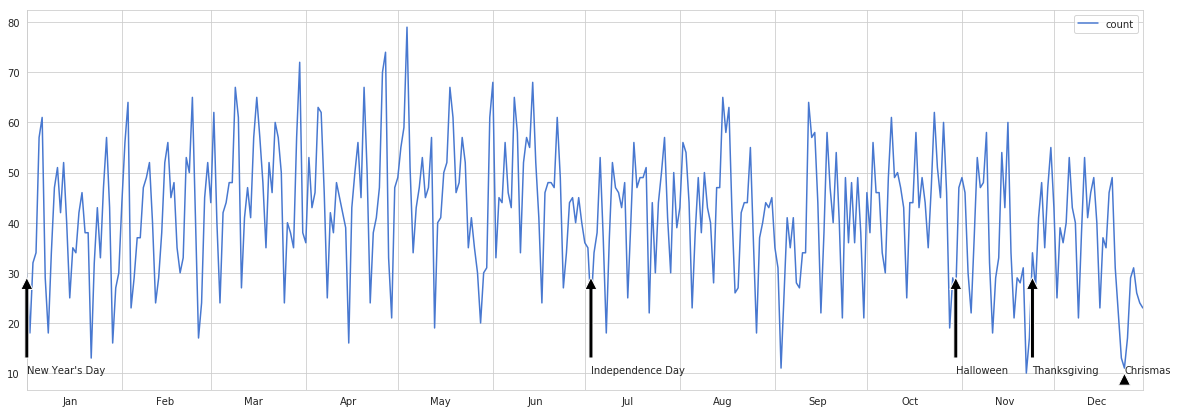

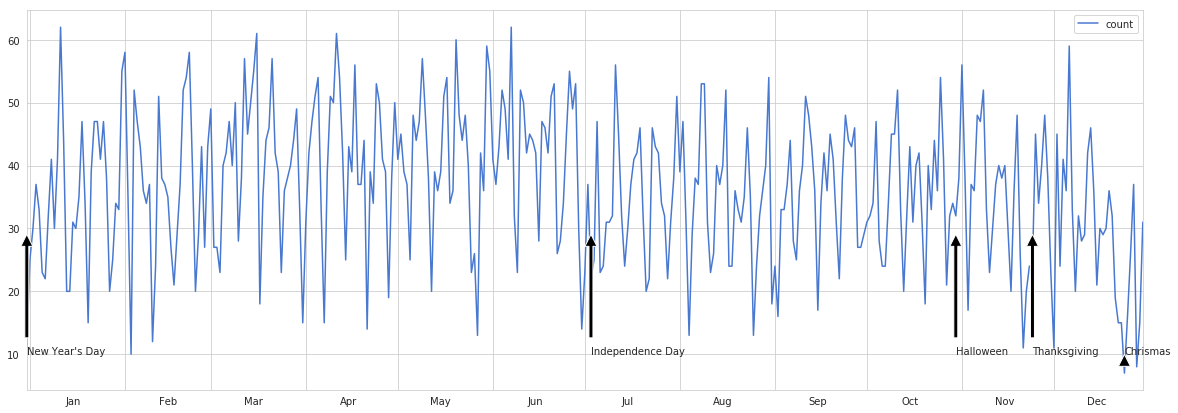

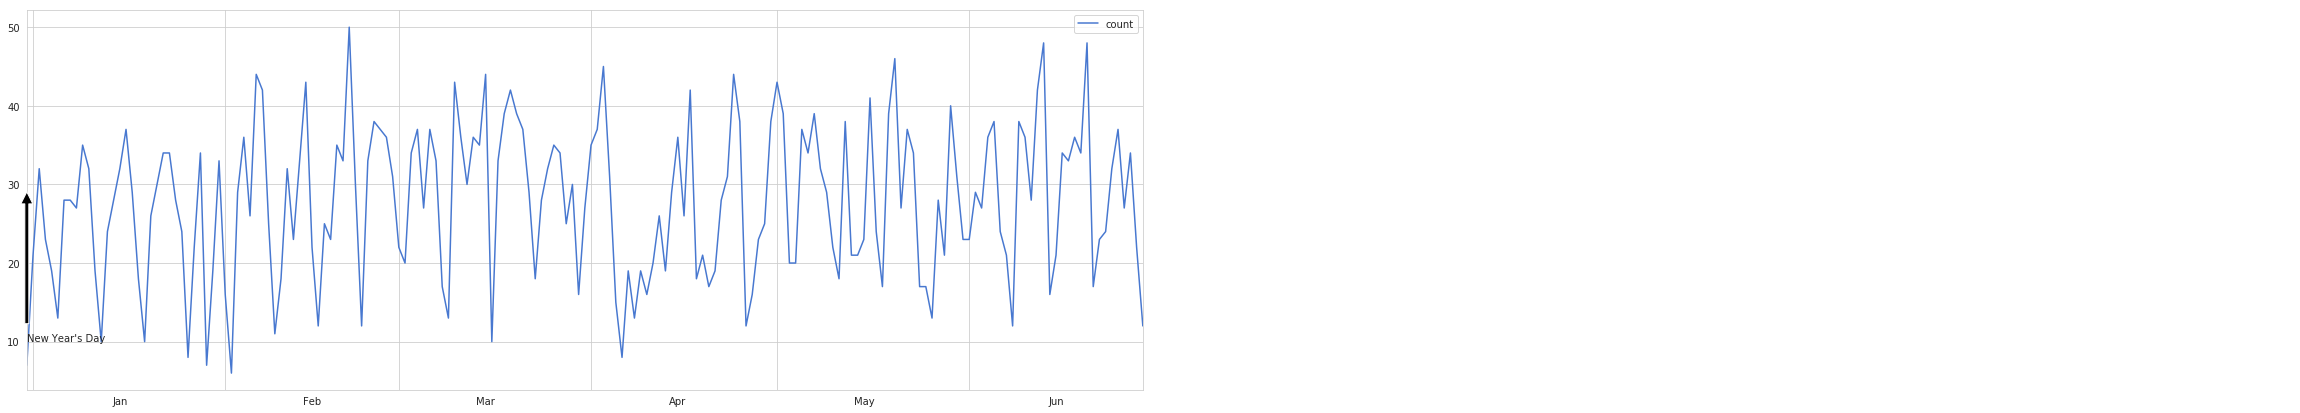

In [15]:
year16 = raw[raw['start_year']==2016]
data_prep.priceVSday(year16, 2016)
year17 = raw[raw['start_year']==2017]
data_prep.priceVSday(year17, 2017)
year18 = raw[raw['start_year']==2018]
data_prep.priceVSday(year18, 2018)
year18 = raw[raw['start_year']==2019]
data_prep.priceVSday(year18, 2019)

The taxi demands in US holidays seem lower than normal days.

### <font color='green'>Q9: Does holiday/weekday/weekend affect the taxi price per mile?</font>

In [16]:
raw['is_holiday'] = data_prep.is_holiday(raw, 'trip_start_timestamp')

In [17]:
raw['is_weekend'] = data_prep.is_weekend(raw, 'dayOfWeek')

In [18]:
raw['price_per_mile'] = raw['fare']/raw['trip_miles']
raw[['price_per_mile', 'fare', 'trip_miles', 'is_holiday', 'dayOfWeek', 'is_weekend']].head()

,price_per_mile,fare,trip_miles,is_holiday,dayOfWeek,is_weekend
0,5.000000,11.50,2.30,False,5,False
1,2.770701,130.50,47.10,False,4,False
2,2.583333,46.50,18.00,False,2,False
3,6.192661,6.75,1.09,False,3,False
4,3.088235,21.00,6.80,False,5,False


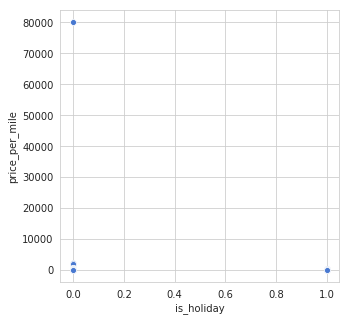

In [19]:
data_prep.scatter_plot(raw, 'is_holiday', 'price_per_mile')

The dataset may contain outliers

### <font color='green'>Q10: Does average trip miles affect by hour, day, month?</font>

<Figure size 576x576 with 0 Axes>

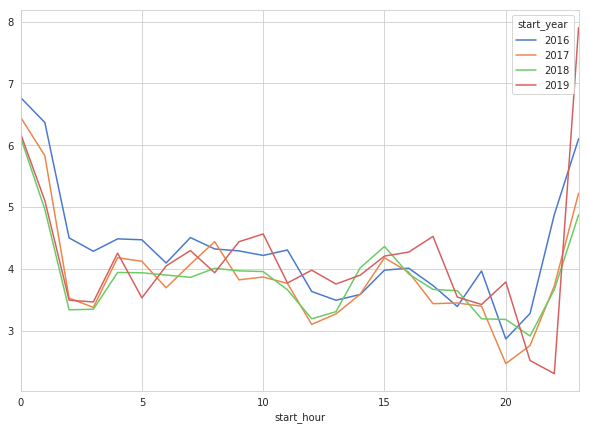

In [20]:
plt.figure(figsize=(8, 8))
pd.pivot_table(raw, columns='start_year', index=['start_hour'], aggfunc='mean', values='trip_miles' ).plot(figsize=(10,7), subplots=False, use_index=True)
plt.show()

<Figure size 576x576 with 0 Axes>

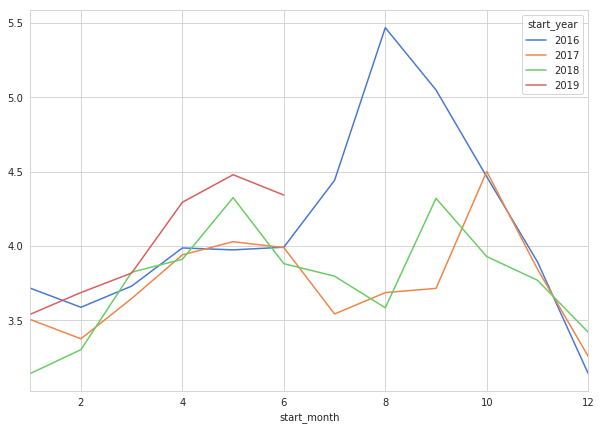

In [21]:
plt.figure(figsize=(8, 8))
pd.pivot_table(raw, columns='start_year', index=['start_month'], aggfunc='mean', values='trip_miles' ).plot(figsize=(10,7), subplots=False, use_index=True)
plt.show()

<Figure size 576x576 with 0 Axes>

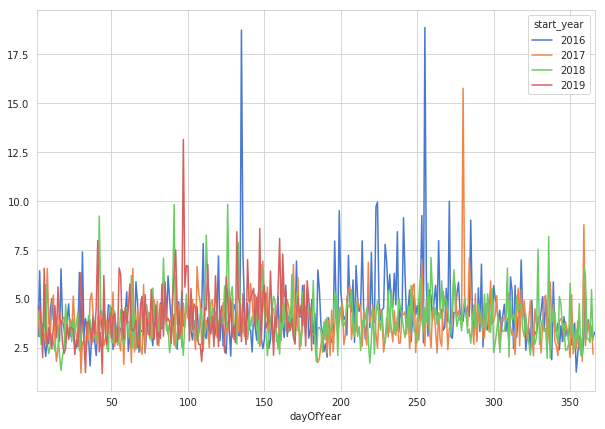

In [22]:
plt.figure(figsize=(8, 8))
pd.pivot_table(raw, columns='start_year', index=['dayOfYear'], aggfunc='mean', values='trip_miles' ).plot(figsize=(10,7), subplots=False, use_index=True)
plt.show()

### <font color='red'>Takeaway #3:</font> <font color='orange'> Time-related feature do show patterns to fare price, and may contain outliers</font>

## Outlier detection && removing outliers

will use location, time information, to detect outlier fares in the dataset

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


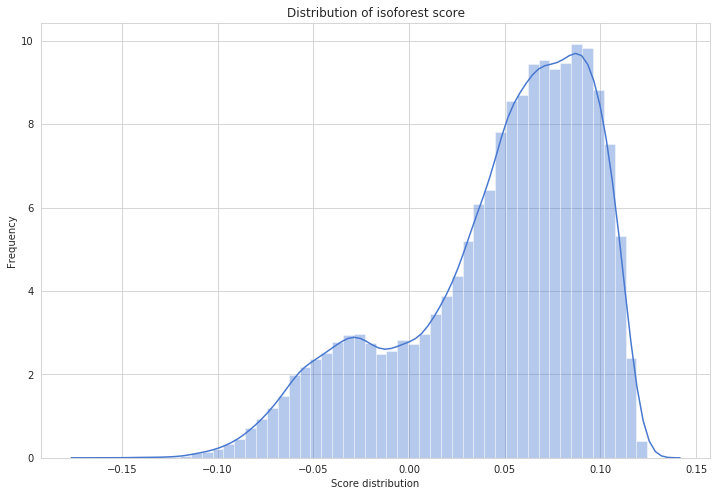

In [29]:
# run isolation forest to identify anomalies
df = raw[['trip_miles', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', \
       'start_year', 'start_month', 'start_hour', 'dayOfWeek', 'trip_seconds',\
        'end_year', 'end_month', 'end_hour',
       'dayOfYear', 'price_per_mile']]
anomaly_model = data_prep.iForest(df)
scale_df = anomaly_model.scale()
scores = anomaly_model.model(scale_df)
df['Anomaly_Scores'] = scores
df = df.sort_values('Anomaly_Scores')

#Plot the distribution of the scores 
plt.figure(figsize=(12, 8))
sns.distplot(df['Anomaly_Scores'], 50)
plt.xlabel('Score distribution')
plt.ylabel('Frequency')
plt.title("Distribution of isoforest score")
plt.show()

In [30]:
print('raw dataframe shape is:', raw.shape)
df = df[(df['Anomaly_Scores']>0.05) & (df['Anomaly_Scores']<0.1)]
print('dataframe shape after removing outliers is:', df.shape)
df = df.drop(['Anomaly_Scores'], axis=1)

raw dataframe shape is: (51683, 26)
dataframe shape after removing outliers is: (24074, 16)


### <font color='green'>Q11: Does trip distance affect fare per mile? </font>

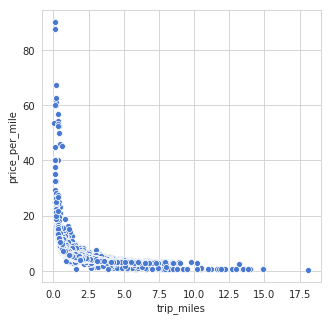

In [31]:
data_prep.scatter_plot(df, 'trip_miles', 'price_per_mile')

If travel for long distance, then the price per mile is lower

### <font color='green'>Q12: Does trip duration  affect fare per mile? </font>

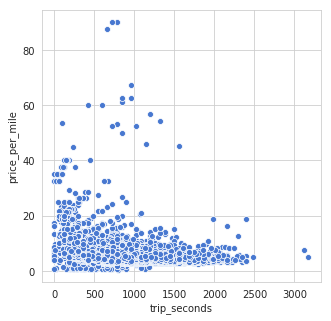

In [32]:
data_prep.scatter_plot(df, 'trip_seconds', 'price_per_mile')

In [33]:
df.to_csv('data.csv', index=False)

## Train & Test dataset preparation

In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd

train = df[(df['start_year']==2016) | (df['start_year']==2017) | (df['start_year']==2018)]
test = df[df['start_year']==2019]

In [35]:
train = train.drop(['start_year', 'end_year'], axis=1)
test = test.drop(['start_year', 'end_year'], axis=1)

In [36]:
train.head()

,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,start_month,start_hour,dayOfWeek,trip_seconds,end_month,end_hour,dayOfYear,price_per_mile
42922,0.79,41.879255,-87.642649,41.880994,-87.632746,10,2,2,269,10,2,275,6.962025
639,3.70,41.899602,-87.633308,41.922686,-87.649489,1,8,3,600,1,8,27,3.243243
16714,0.62,41.899602,-87.633308,41.874005,-87.663518,8,21,1,156,8,21,219,7.258065
23896,1.80,41.898332,-87.620763,41.880994,-87.632746,11,3,1,540,11,3,317,4.583333
38242,1.10,41.892042,-87.631864,41.891972,-87.612945,12,17,5,420,12,17,342,5.909091


In [37]:
train.shape

(22578, 13)

In [38]:
test.shape

(1496, 13)

In [39]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [41]:
import pandas_gbq
destination_table = 'demo3_v2.train'
project_id = 'hackathon1-183523'
private_key = 'hackathon1-183523-95bf3ddffba2.json'
pandas_gbq.to_gbq(
  train,
  destination_table,
  project_id,
  private_key=private_key,
  if_exists='append'
)

1it [00:00,  2.46it/s]


In [42]:
import pandas_gbq
destination_table = 'demo3_v2.test'
project_id = 'hackathon1-183523'
private_key = 'hackathon1-183523-95bf3ddffba2.json'
pandas_gbq.to_gbq(
  test,
  destination_table,
  project_id,
  private_key=private_key,
  if_exists='append'
)

1it [00:05,  5.06s/it]


# End of Feature Engineering